In [2]:
from chainer.datasets import mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train_val, test = mnist.get_mnist(withlabel=True, ndim=1)

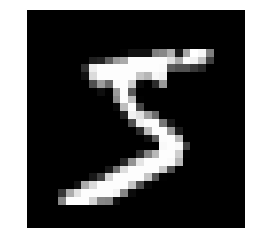

label: 5


In [3]:
# matplotlibを使ったグラフ描画結果がnotebook内に表示されるようにします。
%matplotlib inline
import matplotlib.pyplot as plt

# データの例示
x, t = train_val[0]  # 0番目の (data, label) を取り出す
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label:', t)

In [4]:
from chainer.datasets import split_dataset_random

train, valid = split_dataset_random(train_val, 50000, seed=0)

print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))

Training dataset size: 50000
Validation dataset size: 10000


In [5]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(
    valid, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(
    test, batchsize, repeat=False, shuffle=False)

In [6]:
import random
import numpy
import chainer

def reset_seed(seed=0):
    random.seed(seed)
    numpy.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed(0)

In [7]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()

        # パラメータを持つ層の登録
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0  # CPUを用いる場合は、この値を-1にしてください

net = MLP()

if gpu_id >= 0:
    net.to_gpu(gpu_id)

In [8]:
print('1つ目の全結合層のバイアスパラメータの形は、', net.l1.b.shape)
print('初期化直後のその値は、', net.l1.b.array)


1つ目の全結合層のバイアスパラメータの形は、 (100,)
初期化直後のその値は、 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [9]:
from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01).setup(net)

In [11]:
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:

    # ---------- 学習の1イテレーション ----------
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch, gpu_id)

    # 予測値の計算
    y = net(x)

    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)

    # 勾配の計算
    net.cleargrads()
    loss.backward()

    # パラメータの更新
    optimizer.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # ロスの表示
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        valid_losses = []
        valid_accuracies = []
        while True:
            valid_batch = valid_iter.next()
            x_valid, t_valid = concat_examples(valid_batch, gpu_id)

            # Validationデータをforward
            with chainer.using_config('train', False), \
                    chainer.using_config('enable_backprop', False):
                y_valid = net(x_valid)

            # ロスを計算
            loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
            valid_losses.append(to_cpu(loss_valid.array))

            # 精度を計算
            accuracy = F.accuracy(y_valid, t_valid)
            accuracy.to_cpu()
            valid_accuracies.append(accuracy.array)

            if valid_iter.is_new_epoch:
                valid_iter.reset()
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(valid_losses), np.mean(valid_accuracies)))

# テストデータでの評価
test_accuracies = []
while True:
    test_batch = test_iter.next()
    x_test, t_test = concat_examples(test_batch, gpu_id)

    # テストデータをforward
    with chainer.using_config('train', False), \
            chainer.using_config('enable_backprop', False):
        y_test = net(x_test)

    # 精度を計算
    accuracy = F.accuracy(y_test, t_test)
    accuracy.to_cpu()
    test_accuracies.append(accuracy.array)

    if test_iter.is_new_epoch:
        test_iter.reset()
        break

print('test_accuracy:{:.04f}'.format(np.mean(test_accuracies)))

test_accuracy:0.9225


In [14]:
from chainer import serializers

serializers.save_npz('my_mnist.model', net)

In [15]:
# まず同じネットワークのオブジェクトを作る
infer_net = MLP()

# そのオブジェクトに保存済みパラメータをロードする
serializers.load_npz('my_mnist.model', infer_net)

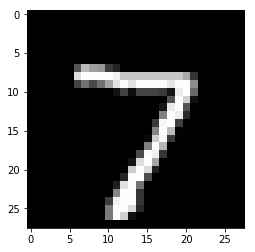

元の形： (784,) -> ミニバッチの形にしたあと： (1, 784)
ネットワークの予測: 7


In [21]:
gpu_id = 0  # CPUで計算をしたい場合は、-1を指定してください

if gpu_id >= 0:
    infer_net.to_gpu(gpu_id)

# 1つ目のテストデータを取り出します
x, t = test[0]  #  tは使わない

# どんな画像か表示してみます
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()

# ミニバッチの形にする（複数の画像をまとめて推論に使いたい場合は、サイズnのミニバッチにしてまとめればよい）
print('元の形：', x.shape, end=' -> ')

x = x[None, ...]

print('ミニバッチの形にしたあと：', x.shape)

# ネットワークと同じデバイス上にデータを送る
x = infer_net.xp.asarray(x)

# モデルのforward関数に渡す
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = infer_net(x)

# Variable形式で出てくるので中身を取り出す
y = y.array

# 結果をCPUに送る
y = to_cpu(y)

# 予測確率の最大値のインデックスを見る
pred_label = y.argmax(axis=1)

print('ネットワークの予測:', pred_label[0])